# Cryptosystem Identifier

In [2]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import collections
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import encrypt
import re
import seaborn as sns
sns.set(color_codes=True)

In [4]:
def getFrequencyOfText(inputText):
    d = collections.Counter(inputText)
    d.pop(' ', -1) # remove space
    b = sorted(list(d.values()), reverse=True)
    n = sum(b)+0.0
    b.extend([0] * (26-len(b)))
    b = np.array(b, dtype=float)
    b = 100*(b/n)
    return b

In [5]:
simple_sub = open("./data_gen/data/train/simple_sub_long.txt").read().splitlines()
vigenere = open("./data_gen/data/train/vig_long.txt").read().splitlines()

In [6]:
N = 2000
M = 26 # Number of features
simple_sub = simple_sub[:N]
vigenere = vigenere [:N]

In [7]:
plain_text = "IN CRYPTOGRAPHY A SUBSTITUTION CIPHER IS A METHOD OF ENCRYPTING BY WHICH UNITS OFPLAINTEXT ARE REPLACED WITH CIPHERTEXT ACCORDING TO A FIXED SYSTEM THE UNITSMAY BE SINGLE LETTERS THE MOST COMMONPAIRS OF LETTERS TRIPLETS OF LETTERS MIXTURES OF THE ABOVE AND SO FORTHTHE RECEIVER DECIPHERS THE TEXT BY PERFORMING THE INVERSE SUBSTITUTION"
key = "VIGENERE"
vigenere_text = encrypt.vigenere(key, plain_text)
key = "THECOWSGMINFLDABJKPQRUVXYZ"
simple_subs_text = encrypt.simple_subs(key, plain_text)

* First we obtain vector representations of our text, which basically is just frequency of occurence of characters sorted in decreasing frequency.
* We use this because in simple substitution if we use the sorted frequency the distribution remains same because E -> W or F-> G then the distribution of frequency of characters would remain unchanged if we sort it in increasing or decreasing manner. But this would not hold true for vigenere cipher. 
* Also one knows english language has a certain distribution of frequency of character while simple substitution would hold that distribution but vigenere cipher would not, since same character may be replaced by different characters in case of vigenere cipher.

In [8]:
p = getFrequencyOfText(plain_text)
v = getFrequencyOfText(vigenere_text)
s = getFrequencyOfText(simple_subs_text)

* We can observe above mentioned statements in the following curve.

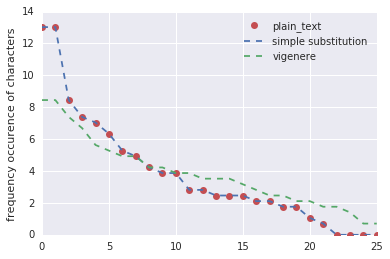

In [9]:
plt.plot(p, 'ro',label='plain_text')
plt.plot(s, label='simple substitution', linestyle="--")
plt.plot(v, label='vigenere', linestyle="--")
plt.ylabel("frequency occurence of characters")
plt.xlabel("")
plt.legend()
plt.show()

Plaintext is completely hidden by kdeplot for simple substitution

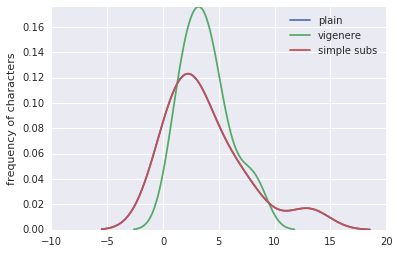

In [10]:
# Plotting kernel density estimation plots
sns.kdeplot(p, label = "plain")
sns.kdeplot(v, label="vigenere")
plt.ylabel('frequency of characters')
sns.kdeplot(s, label="simple subs")
plt.show()

* Plain text distribution is completely hidden by simple subs which is quite obvious due to the choice of the features used
* Therefore choosing features based on this would help us classify
* Input would be a feature vector of frequency of characters, sorted in a descending order. Sorting is done to have uniformity in case of different keys which may be used while testing. 

In [11]:
def get_training_data():
    """ Returns 
        x -> 2000, 27
        y -> 2000, 1
        0 for vigenere and 1 for simple subs
    """ 
    xs = np.ones((int(N/2), M+1))
    xv = np.ones((int(N/2), M+1))
    for i in range(int(N/2)):
        s = getFrequencyOfText(simple_sub[i])
        v = getFrequencyOfText(vigenere[i])
        
        xs[i, 1:] = s
        xv[i, 1:] = v
    
    x = np.vstack((xv, xs))
    
    target = [0]*1000 + [1]*1000
    num_labels = len(np.unique(target))
    y = np.eye(num_labels)[target]
    
    return x, y        

## Neural Network Approach

In [12]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

# NOTE: In order to make the code simple, we rewrite x * W_1 + b_1 = x' * W_1'
# where x' = [x | 1] and W_1' is the matrix W_1 appended with a new row with elements b_1's.
# Similarly, for h * W_2 + b_2
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

In [13]:
all_X, all_Y = get_training_data()

In [14]:
train_X, test_X, train_y, test_y = train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

In [15]:
# Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 26 features and 1 bias
h_size = 256                # Number of hidden nodes
y_size = train_y.shape[1]   # Number of outcomes 2

# Symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])

# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

# Forward propagation
yhat    = forwardprop(X, w_1, w_2)
predict = tf.argmax(yhat, axis=1)

# Backward propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
updates = tf.train.AdamOptimizer().minimize(cost)

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(10):
    # Train with each example
    for i in range(len(train_X)):
        sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})
    train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                             sess.run(predict, feed_dict={X: train_X, y: train_y}))
    test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                             sess.run(predict, feed_dict={X: test_X, y: test_y}))
    print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
          % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch = 1, train accuracy = 99.55%, test accuracy = 99.70%
Epoch = 2, train accuracy = 99.63%, test accuracy = 99.70%
Epoch = 3, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 4, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 5, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 6, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 7, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 8, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 9, train accuracy = 99.48%, test accuracy = 99.85%
Epoch = 10, train accuracy = 99.48%, test accuracy = 99.85%


In [16]:
y_pred = sess.run(predict, feed_dict={X:test_X})

In [18]:
test_y = np.argmax(test_y, axis=1)

In [19]:
accuracy_score(test_y, y_pred)

0.9984848484848485

In [20]:
print(classification_report(test_y, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       325
          1       1.00      1.00      1.00       335

avg / total       1.00      1.00      1.00       660



## Testing Neural Network the test set given 

In [21]:
vig = open("./data_gen/data/test/vig.txt").read().splitlines()
ss = open("./data_gen/data/test/simple_sub.txt").read().splitlines()

* Vigenere has label 0 and Simple substitution has label 1

In [22]:
# Testing for vigenere
res = []
for line in vig:
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(line).reshape(1, -1)
    out = sess.run(predict, feed_dict={ X:x })
    res += [out]

* Output should be 0 for vigenere

In [23]:
res

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0])]

In [24]:
# Testing for simple substitution
res = []
for line in ss:
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(line).reshape(1, -1)
    out = sess.run(predict, feed_dict={ X:x })
    res += [out]

* Output label should be one for simple substitution

In [25]:
res

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

* As we can see we have 100 percent accuracy for test set provided.

## SVM Approach

In [26]:
all_X.shape

(2000, 27)

In [27]:
all_Y = np.hstack((np.zeros(1000), np.ones(1000)))

In [28]:
all_Y.shape

(2000,)

In [29]:
train_X, test_X, train_y, test_y = train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

In [30]:
clf = SVC()
clf.fit(train_X, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
y_pred = clf.predict(test_X)

In [32]:
y_pred.shape, test_X.shape

((660,), (660, 27))

In [33]:
accuracy_score(test_y, y_pred)

0.9984848484848485

* Therefore we have a 99.8 percent accuracy on the test set. Therefore we do not need to tune hyperparameters.

In [34]:
print(classification_report(test_y, y_pred))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       325
        1.0       1.00      1.00      1.00       335

avg / total       1.00      1.00      1.00       660



## Testing SVM on the test set

In [35]:
vig = open("./data_gen/data/test/vig.txt").read().splitlines()
ss = open("./data_gen/data/test/simple_sub.txt").read().splitlines()

In [36]:
res = []
for line in vig:
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(line).reshape(1, -1)
    out = clf.predict(x)
    res += [out]

In [37]:
res

[array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.])]

In [38]:
res = []
for line in ss:
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(line).reshape(1, -1)
    out = clf.predict(x)
    res += [out]

In [39]:
res

[array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.])]

* SVM also gives 100 percent accuracy on the test set

### Let's test it out even more

In [40]:
def test_it(text):
    x = np.ones((1, 27))
    x[:, 1:] = getFrequencyOfText(text).reshape(1, -1)
    out_nn = sess.run(predict, feed_dict={ X:x })
    out_svm = clf.predict(x)
    return out_nn, out_svm

In [41]:
v = "The Vigenere cipher (French pronunciation: ​[viʒnɛːʁ]) \
    is a method of encrypting alphabetic text by using a series\
    of interwoven Caesar ciphers based on the letters of a keyword. It \
    is a form of polyalphabetic substitution. \
    Though the cipher is easy to understand and implement, for three \
    centuries it resisted all attempts to break it; this earned it the \
    description le chiffre indéchiffrable (French for 'the indecipherable cipher'). "

In [42]:
clean_text = ''.join(re.findall('[A-Za-z ]', v)).upper().strip()

In [43]:
clean_text

'THE VIGENERE CIPHER FRENCH PRONUNCIATION VIN     IS A METHOD OF ENCRYPTING ALPHABETIC TEXT BY USING A SERIES    OF INTERWOVEN CAESAR CIPHERS BASED ON THE LETTERS OF A KEYWORD IT     IS A FORM OF POLYALPHABETIC SUBSTITUTION     THOUGH THE CIPHER IS EASY TO UNDERSTAND AND IMPLEMENT FOR THREE     CENTURIES IT RESISTED ALL ATTEMPTS TO BREAK IT THIS EARNED IT THE     DESCRIPTION LE CHIFFRE INDCHIFFRABLE FRENCH FOR THE INDECIPHERABLE CIPHER'

In [44]:
key = "VIGENERE"
cipher = encrypt.vigenere(key, clean_text)

In [45]:
cipher
test_it(cipher)

(array([0]), array([0.]))

* Therefore both neural network and svm predict correct that it was ciphered using a vigenere cipher

In [46]:
s = "In cryptography, a substitution cipher is a method of encrypting by which units of\
plaintext are replaced with ciphertext, according to a fixed system; the units\
may be single letters (the most common),\
pairs of letters, triplets of letters, mixtures of the above, and so forth.\
The receiver deciphers the text by performing the inverse substitution."

In [47]:
clean_text = ''.join(re.findall('[A-Za-z ]', s)).upper().strip()

In [48]:
clean_text

'IN CRYPTOGRAPHY A SUBSTITUTION CIPHER IS A METHOD OF ENCRYPTING BY WHICH UNITS OFPLAINTEXT ARE REPLACED WITH CIPHERTEXT ACCORDING TO A FIXED SYSTEM THE UNITSMAY BE SINGLE LETTERS THE MOST COMMONPAIRS OF LETTERS TRIPLETS OF LETTERS MIXTURES OF THE ABOVE AND SO FORTHTHE RECEIVER DECIPHERS THE TEXT BY PERFORMING THE INVERSE SUBSTITUTION'

In [49]:
key = "THECOWSGMINFLDABJKPQRUVXYZ"

In [50]:
cipher = encrypt.simple_subs(key, clean_text)
test_it(cipher)

(array([1]), array([1.]))

* Therefore both neural network and svm predict correct that it was ciphered using a vigenere cipher

In [51]:
sess.close()